In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import h5py
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import HDF5Matrix
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))
print(tf.__version__)
import datetime

Num GPUs Available:  0
2.3.0


In [2]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0']


In [3]:
Directory = os.getcwd()

INH5 = Directory + 'images_fixed.hdf5' #+ 'Not_Annotated_Images.hdf5' #dynamic range fixed  w/ min-max normalized non-annotated images

MODEL = 'CXR_model.json' #Brian's Lung Model Architechture
WEIGHTS = 'CXR_weights.hdf5' #Brian's Lung Model Weights
print(Directory)

c:\Users\david\Desktop\DSC 180B - WI23


In [4]:
def load_lung_seg_model(model_path, weights_path):
    """ Loads the lung segmentation model built by Brian Hurt, MD, MS (AiDA Lab)

    Args:
        model_path:   path to lung segmentation model architecture
        weights_path: path to lung segmentation model weights

    Returns:
        lung segmentation model (keras Model class) with weights loaded
    """
    # load liver segmentation model
    json_file = open(model_path, 'r'); loaded_model_json = json_file.read()
    json_file.close()
    
    # load model weights
    model = tf.keras.models.model_from_json(loaded_model_json)
    model.load_weights(weights_path) # Load model weights
    
    return model

In [5]:
# Loss = 1 - DICE Function 
def dice_coef_loss_6ch(y_true, y_pred):
    """ Loss = 1 - Dice function built by Evan Masutani, (AiDA Lab)

    Args:
        y_true:   a channels label 
        y_pred: a channels prediction

    Returns:
        lung tupel with Loss = 1 - Dice for each channel
    """
    smooth = 1.
    # Channel 0
    y_true_f_0 = tf.keras.backend.flatten(y_true[...,0])
    y_pred_f_0 = tf.keras.backend.flatten(y_pred[...,0])
    intersection_0 = tf.keras.backend.sum( y_true_f_0 * y_pred_f_0 )
    dice_0 = (2 * intersection_0 + smooth) / (tf.keras.backend.sum(y_true_f_0) + tf.keras.backend.sum(y_pred_f_0) + smooth)
    dice_0_loss = 1. - dice_0
    # Channel 1
    y_true_f_1 = tf.keras.backend.flatten(y_true[...,1])
    y_pred_f_1 = tf.keras.backend.flatten(y_pred[...,1])
    intersection_1 = tf.keras.backend.sum( y_true_f_1 * y_pred_f_1 )
    dice_1 = (2 * intersection_1 + smooth) / (tf.keras.backend.sum(y_true_f_1) + tf.keras.backend.sum(y_pred_f_1) + smooth)
    dice_1_loss = 1. - dice_1
    # Channel 2
    y_true_f_2 = tf.keras.backend.flatten(y_true[...,2])
    y_pred_f_2 = tf.keras.backend.flatten(y_pred[...,2])
    intersection_2 = tf.keras.backend.sum( y_true_f_2 * y_pred_f_2 )
    dice_2 = (2 * intersection_2 + smooth) / (tf.keras.backend.sum(y_true_f_2) + tf.keras.backend.sum(y_pred_f_2) + smooth)
    dice_2_loss = 1. - dice_2
    # Channel 3
    y_true_f_3 = tf.keras.backend.flatten(y_true[...,3])
    y_pred_f_3 = tf.keras.backend.flatten(y_pred[...,3])
    intersection_3 = tf.keras.backend.sum( y_true_f_3 * y_pred_f_3 )
    dice_3 = (2 * intersection_3 + smooth) / (tf.keras.backend.sum(y_true_f_3) + tf.keras.backend.sum(y_pred_f_3) + smooth)
    dice_3_loss = 1. - dice_3
    # Channel 4
    y_true_f_4 = tf.keras.backend.flatten(y_true[...,4])
    y_pred_f_4 = tf.keras.backend.flatten(y_pred[...,4])
    intersection_4 = tf.keras.backend.sum( y_true_f_4 * y_pred_f_4 )
    dice_4 = (2 * intersection_4 + smooth) / (tf.keras.backend.sum(y_true_f_4) + tf.keras.backend.sum(y_pred_f_4) + smooth)
    dice_4_loss = 1. - dice_4
    # Channel 5
    y_true_f_5 = tf.keras.backend.flatten(y_true[...,5])
    y_pred_f_5 = tf.keras.backend.flatten(y_pred[...,5])
    intersection_5 = tf.keras.backend.sum( y_true_f_5 * y_pred_f_5 )
    dice_5 = (2 * intersection_5 + smooth) / (tf.keras.backend.sum(y_true_f_5) + tf.keras.backend.sum(y_pred_f_5) + smooth)
    dice_5_loss = 1. - dice_5
    return(dice_0_loss + dice_1_loss + dice_2_loss + dice_3_loss + dice_4_loss + dice_5_loss)

In [6]:
inh5 = h5py.File('images_fixed.hdf5','r')
lung_model = load_lung_seg_model(MODEL, WEIGHTS)

images = inh5['training_images']

batch_size = 10

image_pred = lung_model.predict(images[0:10])

f = h5py.File('seg_images_fixed.hdf5','w')
f.create_dataset('training_images',data=image_pred,maxshape=(None,256,256,6))
f.close()

with h5py.File('seg_images_fixed.hdf5','a') as hf:
    for batch in range(10,len(images),batch_size):
        image_pred = lung_model.predict(images[batch:batch+batch_size])
        hf['training_images'].resize((hf['training_images'].shape[0] + image_pred.shape[0]), axis = 0)
        hf['training_images'][-image_pred.shape[0]:] = image_pred
        if batch % 100 == 0:
            print(hf['training_images'].shape)
    print(hf['training_images'].shape)
    hf.close()

(110, 256, 256, 6)
(210, 256, 256, 6)
(310, 256, 256, 6)
(410, 256, 256, 6)
(510, 256, 256, 6)
(610, 256, 256, 6)
(710, 256, 256, 6)
(810, 256, 256, 6)
(910, 256, 256, 6)
(1010, 256, 256, 6)
(1110, 256, 256, 6)
(1210, 256, 256, 6)
(1310, 256, 256, 6)
(1410, 256, 256, 6)
(1510, 256, 256, 6)
(1610, 256, 256, 6)
(1710, 256, 256, 6)
(1810, 256, 256, 6)
(1910, 256, 256, 6)
(2010, 256, 256, 6)
(2110, 256, 256, 6)
(2210, 256, 256, 6)
(2310, 256, 256, 6)
(2410, 256, 256, 6)
(2510, 256, 256, 6)
(2610, 256, 256, 6)
(2710, 256, 256, 6)
(2810, 256, 256, 6)
(2910, 256, 256, 6)
(3010, 256, 256, 6)
(3110, 256, 256, 6)
(3210, 256, 256, 6)
(3310, 256, 256, 6)
(3410, 256, 256, 6)
(3510, 256, 256, 6)
(3610, 256, 256, 6)
(3710, 256, 256, 6)
(3810, 256, 256, 6)
(3910, 256, 256, 6)
(4010, 256, 256, 6)
(4110, 256, 256, 6)
(4210, 256, 256, 6)
(4310, 256, 256, 6)
(4410, 256, 256, 6)
(4510, 256, 256, 6)
(4610, 256, 256, 6)
(4710, 256, 256, 6)
(4810, 256, 256, 6)
(4910, 256, 256, 6)
(5010, 256, 256, 6)
(5110, 25

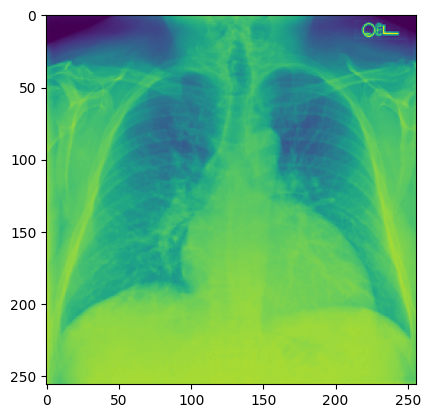

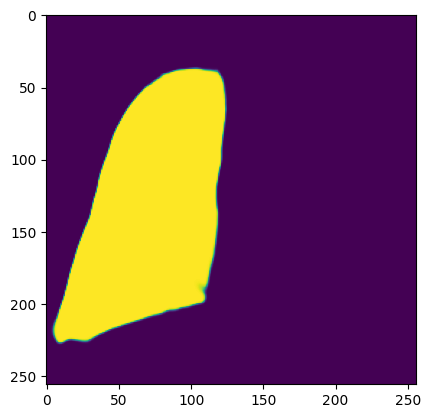

In [21]:
seg = h5py.File('seg_images.hdf5','r')
img = h5py.File('images.hdf5','r')
plt.figure()
plt.imshow(img['training_images'][4])
plt.figure()
plt.imshow(seg['training_images'][4,:,:,0])


non zero pixels 31739590
pixels that equal one 2121
non zero pixels 196608000
pixels that equal one 469865


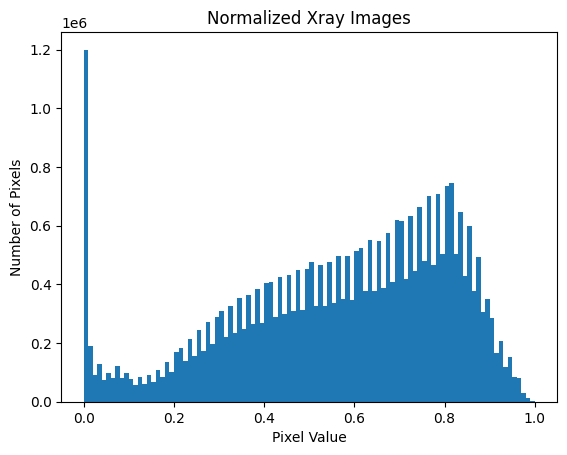

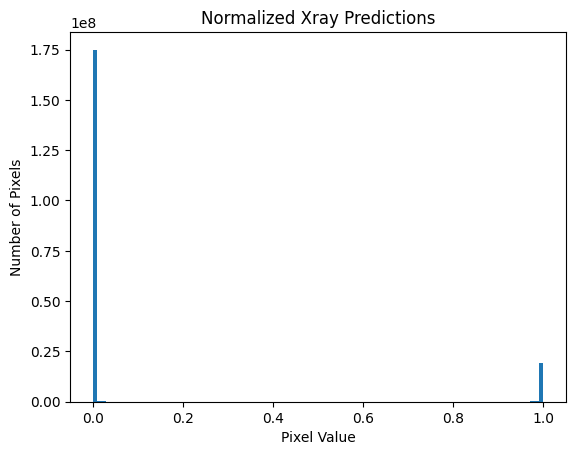

In [18]:
# Checking that images were normalized to 0 - 1 pixels
plt.figure()
plt.title('Normalized Xray Images')
plt.ylabel('Number of Pixels')
plt.xlabel('Pixel Value')
pixels = np.ravel(images)
plt.hist(pixels, bins = 100)
print('non zero pixels' , np.count_nonzero(pixels))
print('pixels that equal one', np.count_nonzero(pixels == 1))

# Checking that images were normalized to 0 - 1 pixels
plt.figure()
plt.title('Normalized Xray Predictions')
plt.ylabel('Number of Pixels')
plt.xlabel('Pixel Value')
pixels = np.ravel(image_predictions)
plt.hist(pixels, bins = 100)
print('non zero pixels' , np.count_nonzero(pixels))
print('pixels that equal one', np.count_nonzero(pixels == 1))


NameError: name 'sns' is not defined

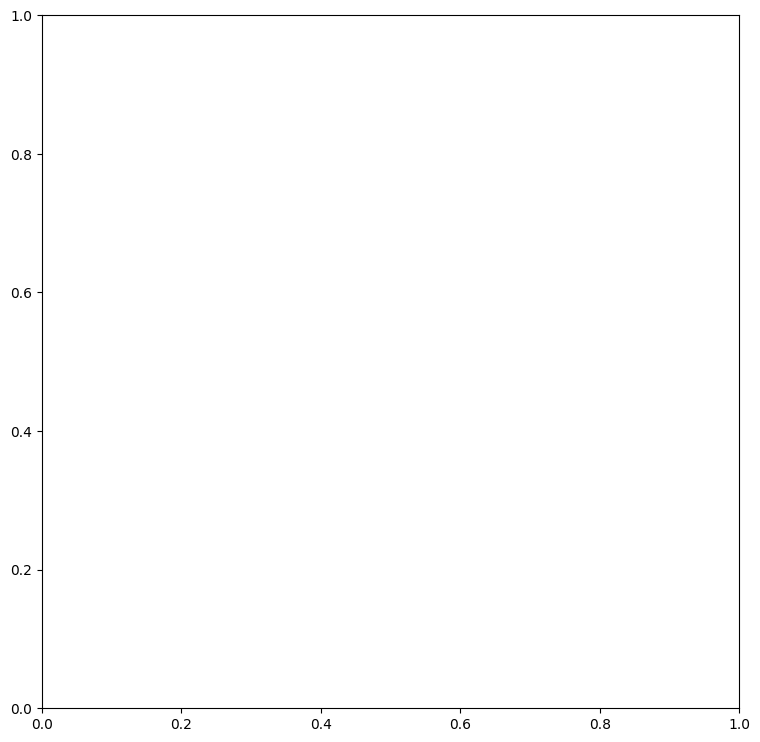

In [19]:
def cutoff_fxn(pred, cutoff):
    pred = np.ravel(pred)
    pred[pred > cutoff] = 1.
    pred[pred < 1] = 0
    return pred

# Prediction Distribution
results = np.zeros((image_predictions.shape[0], image_predictions.shape[-1]))
for i in range(len(image_predictions)):
    for ch in range(image_predictions.shape[-1]):
        results[i,ch] = np.count_nonzero(cutoff_fxn(np.ravel(image_predictions[i,...,ch]),0.095))

# Let's make a swarm plot 
fig = plt.figure(figsize=(9,9))
ax1 = plt.subplot(1,1,1)
ax1 = sns.boxplot(data=[results[:,0], results[:,1], results[:,2], results[:,3], results[:,4], results[:,5]])
ax1 = sns.swarmplot(data=[results[:,0], results[:,1], results[:,2], results[:,3], results[:,4], results[:,5]], color=".2")
plt.title('Size of Masks on Training Labels')
plt.xticks([0,1,2,3,4,5], ('right lung', 'left lung', 'mediastinum', 'right clavicle', 'left clavicle', 'spine'))
ax1.set_ylabel('Number of Pixels with Value of 1')

# Printing Index of Outlier Images in Training
Q1 = np.zeros(results.shape[-1])
Q3 = np.zeros(results.shape[-1])
IQR = np.zeros(results.shape[-1])
anatomy = ['right lung', 'left lung', 'mediastinum', 'right clavicle', 'left clavicle', 'spine']
for ch in range(results.shape[-1]):
    Q1[ch] = np.quantile(results[:,ch], 0.25)
    Q3[ch] = np.quantile(results[:,ch], 0.75)
    IQR[ch] = Q3[ch] - Q1[ch]
    print( anatomy[ch] ,
      '\n\t outlier Image: ',
      np.where((results[:,...,ch] < (Q1[ch] - 1.5 * IQR[ch])) | (results[:,...,ch] > (Q3[ch] + 1.5 * IQR[ch]))))

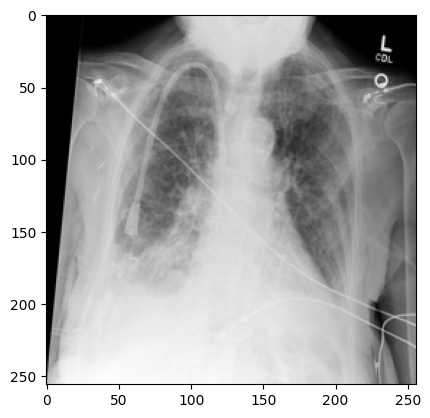

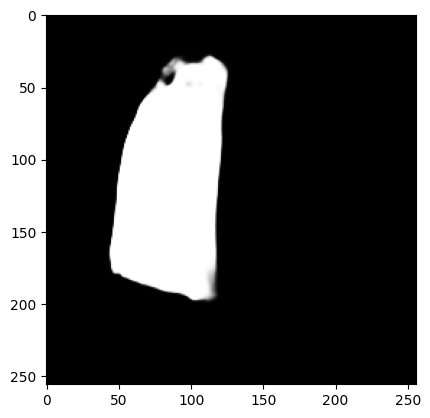

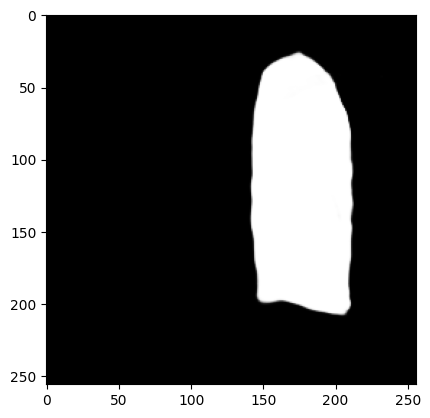

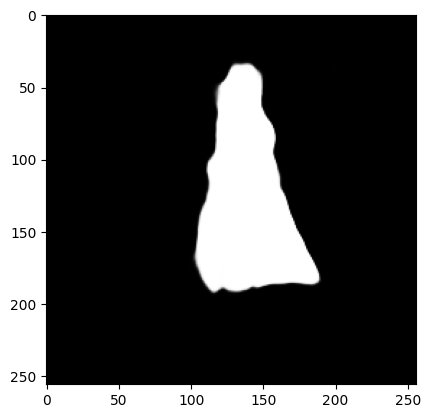

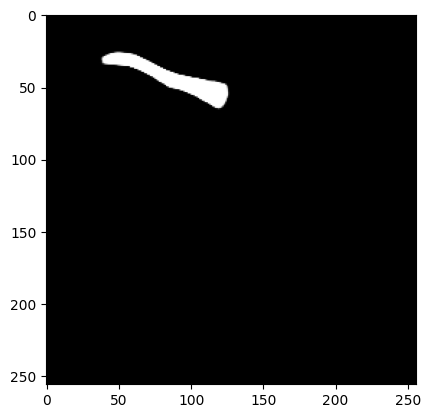

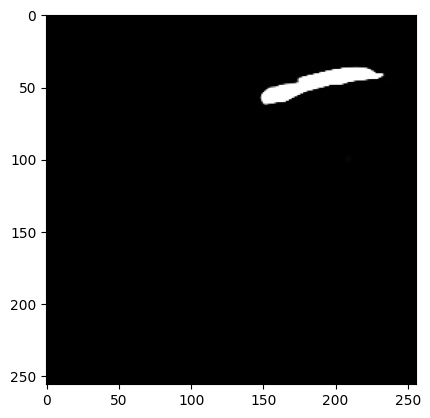

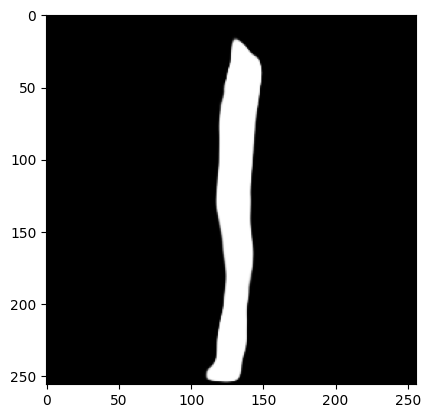

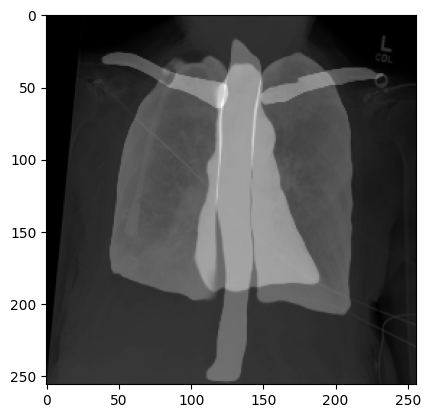

In [10]:
# Sample of image w/ predicted Masks

trainix = 55
plt.figure()
plt.imshow(images[trainix,:,:,0],cmap='gray')
plt.figure()
plt.imshow(image_predictions[trainix,:,:,0],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(image_predictions[trainix,:,:,1],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(image_predictions[trainix,:,:,2],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(image_predictions[trainix,:,:,3],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(image_predictions[trainix,:,:,4],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(image_predictions[trainix,:,:,5],cmap='gray',vmin=0,vmax=1)
plt.figure()
plt.imshow(images[trainix,:,:,0] + image_predictions[trainix,:,:,0] + image_predictions[trainix,:,:,1] + image_predictions[trainix,:,:,2] + image_predictions[trainix,:,:,3] + image_predictions[trainix,:,:,4] + image_predictions[trainix,:,:,5], cmap='gray')


In [11]:
# from the master-image and master-annotation list create Fast-Mask Compatible:
IMAGES = 'Not_Annotated_Images.hdf5'
PREDICTIONS = 'Not_Annotated_Predictions2.hdf5' #changed from 'Not_Annotated_Predictions.hdf5'
img_OUTPUT = 'Not_Annotated_Images_FM2.hdf5' #changed from 'Not_Annotated_Images_FM.hdf5'
pred_OUTPUT = 'Not_Annotated_Predictions_FM2.hdf5' #changed from 'Not_Annotated_Predictions_FM.hdf5'
# Removes old preprocessed hdf5, can comment out as necessary
try:
    os.remove(img_OUTPUT)
    os.remove(pred_OUTPUT)
except:
    pass
imgs = h5py.File(IMAGES,'r')
preds = h5py.File(PREDICTIONS,'r')
img_outh5 = h5py.File(img_OUTPUT,'a')
pred_outh5 = h5py.File(pred_OUTPUT,'a')
# Brian's model uses 256 x 256 inputs so we track this here:
DIMS = 256

In [12]:
#images
# from: unannotated_images has shape (708, 256, 256, 1) and type float32
# to: Abankan_ser_1001_im_1000 has shape (3520, 4280, 1) and type int16
for i in range(len(N_list)):
    try:
        img_outh5.create_dataset(N_list[i], (DIMS, DIMS, 1), data=imgs['unannotated_images'][i], dtype=np.float32)
    except:
        traceback.print_exc() 

In [13]:
#predictions 
# from: unannotated_predictions has shape (708, 256, 256, 6) and type float32
# to: Abankan_ser_1001_im_1000 has shape (3520, 4280, 1, 7) and type float32 <-- channel 7 is all, hoping 6 works
for i in range(len(N_list)):
    try:
        pred_outh5.create_dataset(N_list[i], (DIMS, DIMS, 1, 6), data=preds['unannotated_predictions'][i], dtype=np.float32)
        pred_outh5.create_dataset(N_list[i] + '_dR_dC_NcwRot_UD_LR', (5, ), dtype=np.int16)
    except:
        traceback.print_exc()

In [14]:
imgs.close()
preds.close()
img_outh5.close()
pred_outh5.close()

## If you have run the previous code to create your own Not_Annotated Imgs and Preds

### then you should change to 'Not_Annotated_Images_FM.hdf5' and 'Not_Annotated_Predictions_FM2.hdf5'

In [2]:
inh5_1 = h5py.File('Not_Annotated_Images_FM.hdf5','r') 
inh5_2 = h5py.File('Not_Annotated_Predictions_FM.hdf5','r') 

In [3]:
inh5_1['Abankan_ser_1_im_0']

<HDF5 dataset "Abankan_ser_1_im_0": shape (256, 256, 1), type "<f4">

In [4]:
inh5_2['Abankan_ser_1_im_0']

<HDF5 dataset "Abankan_ser_1_im_0": shape (256, 256, 1, 6), type "<f4">

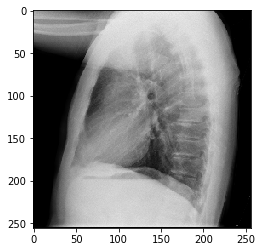

In [5]:
plt.imshow(inh5_1['Abankan_ser_1_im_0'][:,:,0],cmap='gray')

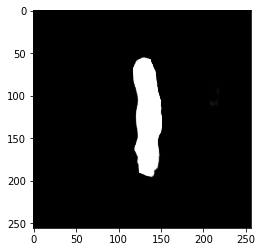

In [6]:
plt.imshow(inh5_2['Abankan_ser_1_im_0'][:,:,0,5],cmap='gray')

In [7]:
inh5_1.close()
inh5_2.close()